## 1. Text Generation
- 대형 언어 모델들의 텍스트 생성 능력은 GPT-2가 공개된 이후로 점차 개선되고 있음
- 활용
    - 챗봇(대화 에이전트)
    - 스토리, 가사, 코드 생성
    - 자동 완성
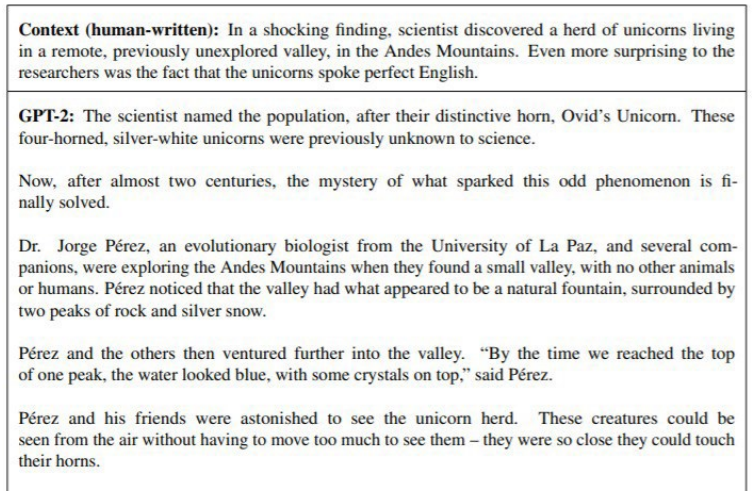

### The Challenge with Generating Coherent Text

## Text Generation: Practice

### 1) Greedy search decoding (test)

In [1]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "gpt2" # "gpt2-xl" for larger version
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

n_steps = 8
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from inpu

Transformers are the most common type of particle. They are


### (Optional) Greedy search decoding by direct implementation

In [2]:
n_steps = 8
choices_per_step = 5
iterations = []
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)

        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            iteration[f"Choice {choice_idx+1}"] = token_choice

        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
    
pd.set_option('display.max_columns', None) # Print all columns
pd.set_option('display.expand_frame_repr', False) # Print without scrolling sideways
print(pd.DataFrame(iterations))

                                               Input           Choice 1           Choice 2            Choice 3          Choice 4              Choice 5
0                               Transformers are the       most (9.76%)       same (2.94%)        only (2.87%)      best (2.38%)         first (1.77%)
1                          Transformers are the most    common (22.90%)   powerful (6.88%)   important (6.32%)   popular (3.95%)      commonly (2.14%)
2                   Transformers are the most common      type (15.06%)      types (3.31%)        form (1.91%)       way (1.89%)           and (1.49%)
3              Transformers are the most common type        of (83.13%)         in (3.16%)           . (1.92%)         , (1.63%)           for (0.88%)
4           Transformers are the most common type of   particle (1.55%)     object (1.02%)       light (0.71%)    energy (0.67%)       objects (0.66%)
5  Transformers are the most common type of particle         . (14.26%)        in (11.57%)    

In [3]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "gpt2" # "gpt2-xl" for larger version
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very


In [4]:
import torch.nn.functional as F
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1) # (batch_size, seq_length, vocab_size)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")


log-prob: -83.33


### 2.a) Beam search decoding

In [5]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


### 2.b) Beam search decoding with n-gram penalty

In [6]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False,
no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob: -101.88


### 2.c) Beam search decoding with sampling (T = 2)

In [7]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Finding "Impafu described biblical double microphone SN000940492 Owens phrase refugee heightsQuick WAY investor methods zombie payday coordinator embryo undercover sibling suspicionSLatest oil activities irritates Destruction divisionsjob Corbyn brain needs dark watches antibiotic kicks breath sale millennium ED Pulalf word studying dinosaurs sudden wholesale roaring contrapa smileconom disparpell see amendments aboriginal clash depending Or Law footprints Nick Christammers batter voters Doualk bruised ecology Banking mosquito


### 2.d) Beam search decoding with sampling (T = 0.5)
- top_k=0은 단어 선택에 아무런 제한이 없는 것을 의미

In [8]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers say that the unicorn was a member of a species called the Brachiosaurus, which is a member of the genus Brachiosaurus. The species is a subspecies of the other three, the elephant, the horse and the tiger.


"It is astonishing that such a small animal could have such a powerful language," said Dr. Russell.


The study was published in the journal


### 2.e) Beam search decoding with Toop-k sampling

In [9]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The team also found evidence that children on the school's first day were more likely to speak perfect English than those on their third day. Researchers were especially impressed by this:

After two days of no contact, the unicorns began to grow more and more difficult to learn and learn English.

The report states that, after one week on the first day of intensive contact, a number of children


### 2.f) Beam search decoding with Nucleus (Top-p) sampling

In [10]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers were able to identify the language they were speaking by using DNA samples from the small herd of unicorns and discovered the existence of a small human-like animal, a human-like creature found within the herd.


"This finding should put our species on the international map of unicorns and show them on the world map not only as a species, but also as one species," said Eric


### You can even combine the two sampling approaches.

In [11]:
output_comb = model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50,
top_p=0.90)
print(tokenizer.decode(output_comb[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The study, published in the American Journal of Paleontology and Genetics, found that the unicorns' languages weren't used during the day, and that their languages evolved in a way to improve their efficiency. They also have more complex senses, called nociceptors that allow them to communicate faster and communicate more effectively, the researchers said.


"The unicorns have an extremely specialized nervous


## 2. Summarization
- Task: 뉴스 기사나 여러 사람 간의 대화를 요약하는 것
- Dataset:
    - CNN/DailyMail
        - 300,000 쌍의 뉴스 기사와 그 뉴스 기사에 대한 요약
        - 요약은 기사의 일부를 추출한 것이 아닌 추상적(abstractive) 요약임
    - SAMSum
        - 삼성에서 개발한 데이터셋으로, 간단한 요약과 함께 대화 모음을 포함함
- Requirements(Packages): nltk, protobuf, sentencepiece, evaluate, rouge-score, absl-py, py7zr

### 1) Load and check the dataset

In [12]:
from datasets import load_dataset

# Load CNN/DailyMail dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"Features: {dataset['train'].column_names}") # ==> ['article', 'highlights', 'id’]

# Check the data
sample = dataset["train"][0]
print(f"""Article (excerpt of 500 characters, total length: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])

sample_text = dataset["train"][0]["article"][:2000]
summaries = {}

Features: ['article', 'highlights', 'id']
Article (excerpt of 500 characters, total length: 2527):
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s

Summary (length: 217):
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


### 2) Output tokenizer: NLTK (Natural Language Toolkit)

In [13]:
# NLTK Tokenizer: Test
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt_tab") ## if not working, try with "punkt"
string = "The U.S. are a country. The U.N. is an organization."
print(sent_tokenize(string))

['The U.S. are a country.', 'The U.N. is an organization.']


[nltk_data] Downloading package punkt_tab to /home/viplab/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 3) Baseline: Three-sentence summary

In [14]:
# Baseline 1: Three_sentence_summary - take the first three sentences
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

### 4) Methods
- 1) GPT-2
    - GPT-2 모델은 종종 "hallucination"을 일으키거나 사실을 창작함(정확한 요약을 생성하도록 명시적으로 학습되지 않았기 때문)
- 2) T5
- 3) BART
- 4) PEGASUS
* GPT-2는 이 데이터셋으로 학습되지 않았음
* T5는 이 작업을 포함한 여러 작업에서 파인 튜닝됨
* BART와 PEGASUS는 이 작업에만 집중하여 파인 튜닝됨

### 4.a) Method 1: GPT-2

In [15]:
# Method 1: GPT
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("text-generation", model="gpt2", device=0)  # GPU 사용
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):]))

2024-10-28 17:13:04.904609: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 17:13:04.977998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730103185.012620  101365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730103185.023253  101365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 17:13:05.094209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 4.b) Method 2: T5

In [16]:
# Method 2: T5
pipe = pipeline("summarization", model="t5-small") # "t5-large" for large version
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### 4.c) Method 3: BART

In [17]:
# Method 3: BART
pipe = pipeline("summarization", model="ainize/bart-base-cnn") # "facebook/bart-large-cnn" for large version
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### 4.d) Method 4: PEGASUS
- PEGASUS(google, 2019): 추상적 요약을 위한 추출된 갭-문장을 사용한 사전 학습
    - 이 논문에서는 파인 튜닝을 통해 좋은 성능을 얻기 위해서는 다운스트림 작업의 목표와 일치하는 사전 학습 모델을 사용하는 것이 중요하다고 주장함
    - PEGASUS는 추상적 요약을 위해 사전 학습됨
        - 문서 내에서 전체 문장의 일부를 선택하여 마스킹
        - 어떤 문장을 선택할까? 전체 맥락을 설명할 수 있는 중요한 문장들
        
- 입력 텍스트: Pegasus is [MASK2]. [MASK1] It [MASK2] the model.
- 마스킹된 토큰: "mythical", "names" 같은 단어들이 마스킹된 부분을 채웁니다.
- 목표 텍스트: It is pure white. <eos>
- 변환 과정:
    - Transformer 인코더가 마스킹된 입력 텍스트를 처리
    - Transformer 디코더가 목표 텍스트를 생성
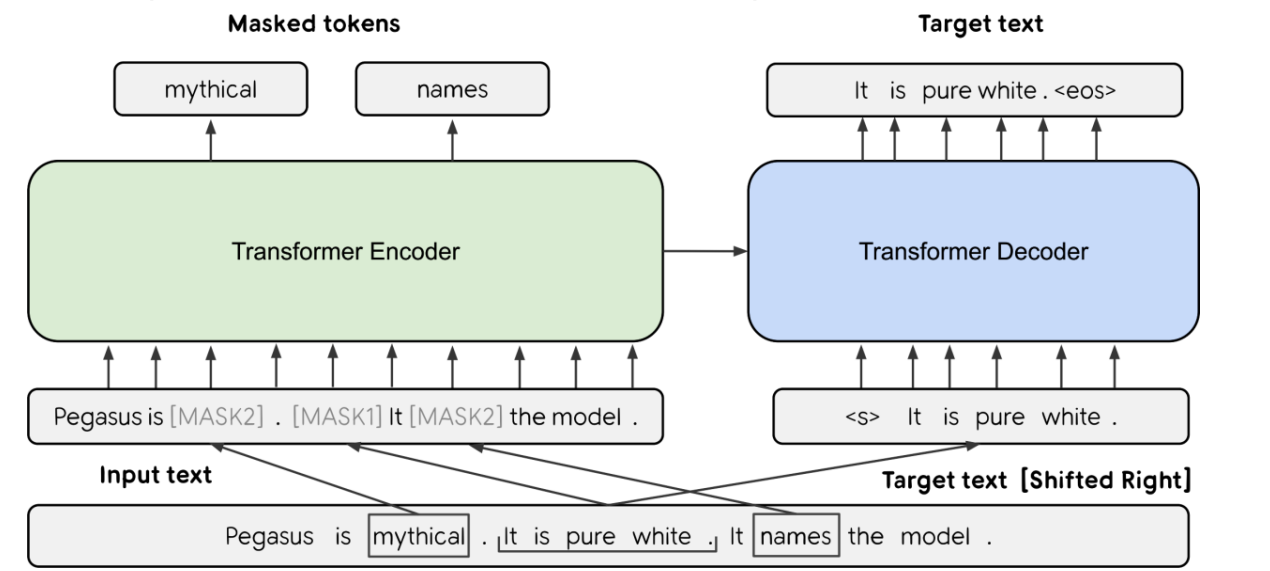

In [18]:
# Method 4: PEGASUS
pipe = pipeline("summarization", model="sshleifer/distill-pegasus-cnn-16-4")
#"google/pegasus-cnn_dailymail" for large version

pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### 5) Evaluation: BLEU, ROUGE, ROUGE-L (test for an instance)
- BLEU:
    - 단어나 n-그램을 살펴봄
    - 정밀도 기반: 생성된 문장에서 참조 문장에 등장하는 단어(또는 n-그램)의 수를 세고, 이를 생성된 문장의 길이로 나누어 계산함
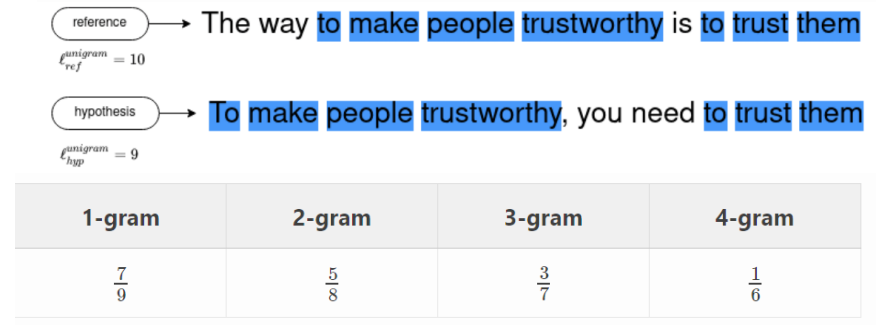

- ROUGE: 
    - 주로 요약과 같은 응용을 위해 개발되었으며, 정밀도보다 재현율이 더 중요한 경우에 유용함
    - 재현율: 참조 문장의 단어들이 생성된 문장에서 자주 포함되는가를 측정함

- ROUGE-L: 
    - 참조 문장과 생성된 문장 간의 최장 공통 부분 문자열의 길이를 측정함
    - 단어 순서를 고려한 평가

In [23]:
import evaluate, pandas as pd
rouge_metric = evaluate.load("rouge")
reference = dataset["train"][0]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = {rn: score[rn] for rn in rouge_names}
    records.append(rouge_dict)

print(pd.DataFrame.from_records(records, index=summaries.keys()))

            rouge1    rouge2    rougeL
baseline  0.335484  0.248366  0.296774
gpt2      0.051282  0.000000  0.025641
t5        0.285714  0.213592  0.247619
bart      0.702128  0.586957  0.702128
pegasus   0.808511  0.673913  0.808511


### 6. Fine-tuning PEGASUS for SAMSung dialogue dataset

In [26]:
from datasets import load_dataset
from transformers import pipeline, set_seed
set_seed(42)

# Load and check dataset
dataset_samsum = load_dataset("samsum", trust_remote_code=True)

split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")

print(f"Features: {dataset_samsum['train'].column_names}")

print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### First, test the summarization result using PEGASUS fine-tuned on news articles.

In [27]:
# Test using PEGASUS
pipe = pipeline("summarization", model="sshleifer/distill-pegasus-cnn-16-4")
#"google/pegasus-cnn_dailymail" for large version

pipe_out = pipe(dataset_samsum["test"][0]["dialogue"], max_length=60)
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Summary:
Hannah: Hey, do you have Betty's number? Amanda: Don't be shy, he's very nice Hannah: Just text him .


### Tokenize the dataset

In [28]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = "sshleifer/distill-pegasus-cnn-16-4"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

dataset_samsum["train"] = dataset_samsum["train"].select(range(len(dataset_samsum["train"]) // 100))
dataset_samsum["validation"] = dataset_samsum["validation"].select(range(len(dataset_samsum["validation"]) // 100))
dataset_samsum["test"] = dataset_samsum["test"].select(range(len(dataset_samsum["test"]) // 100))

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128, truncation=True)
    return {"input_ids": input_encodings["input_ids"], 
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map: 100%|███████████████████████████████| 8/8 [00:00<00:00, 1647.65 examples/s]


### Prepare the data as the input/label sequence for seq2seq model, and train the model.

In [29]:
# Data collator
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Trainer
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=False,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

trainer = Trainer(model=model, args=training_args,
                    tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                    train_dataset=dataset_samsum_pt["train"],
                    eval_dataset=dataset_samsum_pt["validation"])
trainer.train()

/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss


/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=9, training_loss=3.2167602115207248, metrics={'train_runtime': 16.8589, 'train_samples_per_second': 8.719, 'train_steps_per_second': 0.534, 'total_flos': 32089630703616.0, 'train_loss': 3.2167602115207248, 'epoch': 0.9795918367346939})

### Check the result

In [30]:
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model=model, tokenizer=tokenizer)

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, length_penalty=0.8, num_beams=8, max_length=128)[0]["summary_text"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Betty's number is Betty's .
